In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting

import warnings
from collections import namedtuple
import torch.nn.functional as F
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
from torchsummary import summary

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Mount Google Drive
#it will be visible in the file navigator on the left of this notebook
#there should be a folder in your drive with your data
from google.colab import drive
drive.mount('/content/drive/')
# Folder for splitting
!cp -r "/content/drive/MyDrive/Colab Notebooks/TrainValidTest/" "/content/content"

cuda
Mounted at /content/drive/


# Introduction, Motivation and/or Problem Statement
**Clearly define the problem statement or purpose of the project.**

Hand gestures are commonly used in entertainment and games whereby users perform different gestures which are noted by a computer. It is also commonly used in communications where it enhances the experience of conveying information through presentations. Perhaps most importantly, gestures using sign language are commonly used in the deaf community to communicate with the world, allowing them to contribute to society in many ways.


The identification of hand gestures can be grouped into two different problems, classification and object detection. Classification involves determining the type of hand gesture present in a set of still images. The hand gestures are normally located in the same coordinates within the images. Object detection adds localisation to classification, to determine the location of a gesture in an image or video. These gestures may also be obstructed or not immediately obvious to the neural network or viewer.


Attempts have been made to perform gesture recognition using computer vision. However, these have not proven to be robust. Therefore, the purpose of this project was to perform image classification on 10 different hand gestures through the training of a neural network on a pre-defined dataset.


# Data Sources or RL Tasks
**Data sources or reinforcement learning tasks are clearly documented and described. Enough detail is provided for the data to be found again.**

The dataset used for gesture recognition was provided by kaggle.com. The dataset contained 10 different hand-gestures made by 10 different subjects (equally split men and women). The images were in grayscale, with minimal noise and of equal dimensions (640x240 pixels).

This dataset can be accessed through the link: https://www.kaggle.com/datasets/gti-upm/leapgestrecog

# Exploratory Analysis of Data or RL Tasks
**Provide details about the properties, number of classes, pre-processing, challenging aspects, etc. of the data (or the RL task).**

20,000 dataset images were provided in greyscale. 

There were 10 classes - which corresponded to 10 different gestures in the dataset:

*   Palm
*   L
*   Fist
*   Fist_moved 
*   Thumb 
*   Index 
*   Ok 
*   Palm_moved 
*   C
*   Down

Coverage was achieved as the dataset was composed through 10 individuals of equally split genders who made 10 different hand gestures. Sufficient quantity was achieved, because each gesture has 200 unique images of the same gesture for each person.

For preprocessing, we resized the images to 227x227 and normalised each pixel in the training images (mapping pixel values from a range of 0 to 255 to a range of 0 to 1).

This was implemented in the code below:




In [ ]:
# The idea is to have one big folder containing train, test and validation data and then separate the data within these three folders into new train, test, validation datasets

class CustomDataset(Dataset):
    def __init__(self, filepath):
        self.imgs_path = filepath # /content/content/
        file_list = sorted(os.listdir(self.imgs_path)) # test, train, valid
        content = []
        for i in file_list:
          content.append(filepath+i) # /content/content/train/,# /content/content/test/,# /content/content/valid/
        self.data = []
        names = []
        for class_path in content:
            folder_name = class_path.split('/')[-1]
            for folder in sorted(os.listdir(filepath + '/' + folder_name + '/')):
                names.append(folder)
                for frame in sorted(os.listdir(filepath + '/' + folder_name + '/' + folder +'/')):
                    self.data.append([frame, folder,folder_name])
        self.class_map = {names[0]: 0,
                          names[1]: 1,
                          names[2]: 2,
                          names[3]: 3,
                          names[4]: 4,
                          names[5]: 5,
                          names[6]: 6,
                          names[7]: 7,
                          names[8]: 8,
                          names[9]: 9}
        self.img_dim = (227, 227)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name, folder_name = self.data[idx]
        input_image = Image.open(self.imgs_path + "/" + folder_name + "/" + class_name + "/" + img_path)
        input_image = input_image.convert('RGB')
        img = input_image.resize((227, 227))
        class_id = self.class_map[class_name]
        class_id = np.asarray(class_id).squeeze()
        img_np = np.asarray(img)
        img_tensor = torch.from_numpy(img_np)
        img_tensor = img_tensor/255
        class_id = torch.from_numpy(class_id)

        # Preprocess Data
        preprocess = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        input_tensor = preprocess(input_image)
        return input_tensor, class_id

There were some challenging aspects of the data. For example, the dataset we used in the beginning was quite large, consisting of 20,000 images. We manually split the data according to 70% training, 20% validation and 10% testing. As the dataset was too large to share digitally in an efficient manner, we could not share the manually split dataset with each other at first. We each individually manually split the dataset in our own way but with the same split ratios which took up a lot of time. However, we implemented code in the program to have automated splitting of the dataset in the ratio 50% training 30% validation and 20% testing later on in the project.

Custom data was also added to the dataset, in the form of 20 self-generated images. Efforts were made to have the images be as similar as possible to the existing images, including the cleaning of the images to minimise noise.

This was implemented in the code below:

In [ ]:
all_dataset = CustomDataset('/content/content/')
train_size = int(0.5 * len(all_dataset))
test_size = int(0.3 * len(all_dataset))
valid_size = len(all_dataset) - train_size - test_size
train_dataset, test_dataset, validation_dataset = torch.utils.data.random_split(all_dataset, [train_size, test_size, valid_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Models and/or Methods
**Model(s) and/or Method(s) are judiciously chosen and appropriately applied. If building on previous work, identify the source and clearly delineate which parts are your own work.**

**GoogLeNet**


GoogLeNet is a convolutional neural network (CNN) developed by Google researchers, a variant of the Inception deep convolutional neural network. Presented at the ImageNet Large-Scale Visual Recognition Challenge 2014 (ILSVRC14), the GoogLeNet architecture addressed computer vision tasks such as image classification and object detection. The GoogLeNet architecture performed well in the classification task in the ILSVRC 2014 classification task and ranked first with 6.67% of the top five errors without training on external data. Today, GoogLeNet offers face detection and recognition, adversary training, and other computer vision tasks.


The GoogLeNet architecture consists of 22 layers, with 9 of its layers made up of Inception modules. The Inception module is a neural network architecture that uses convolution with different filters to reduce the computational cost of training scaled networks by reducing dimensionality and using feature detection at different scales. These layers are shown diagrammatically below:


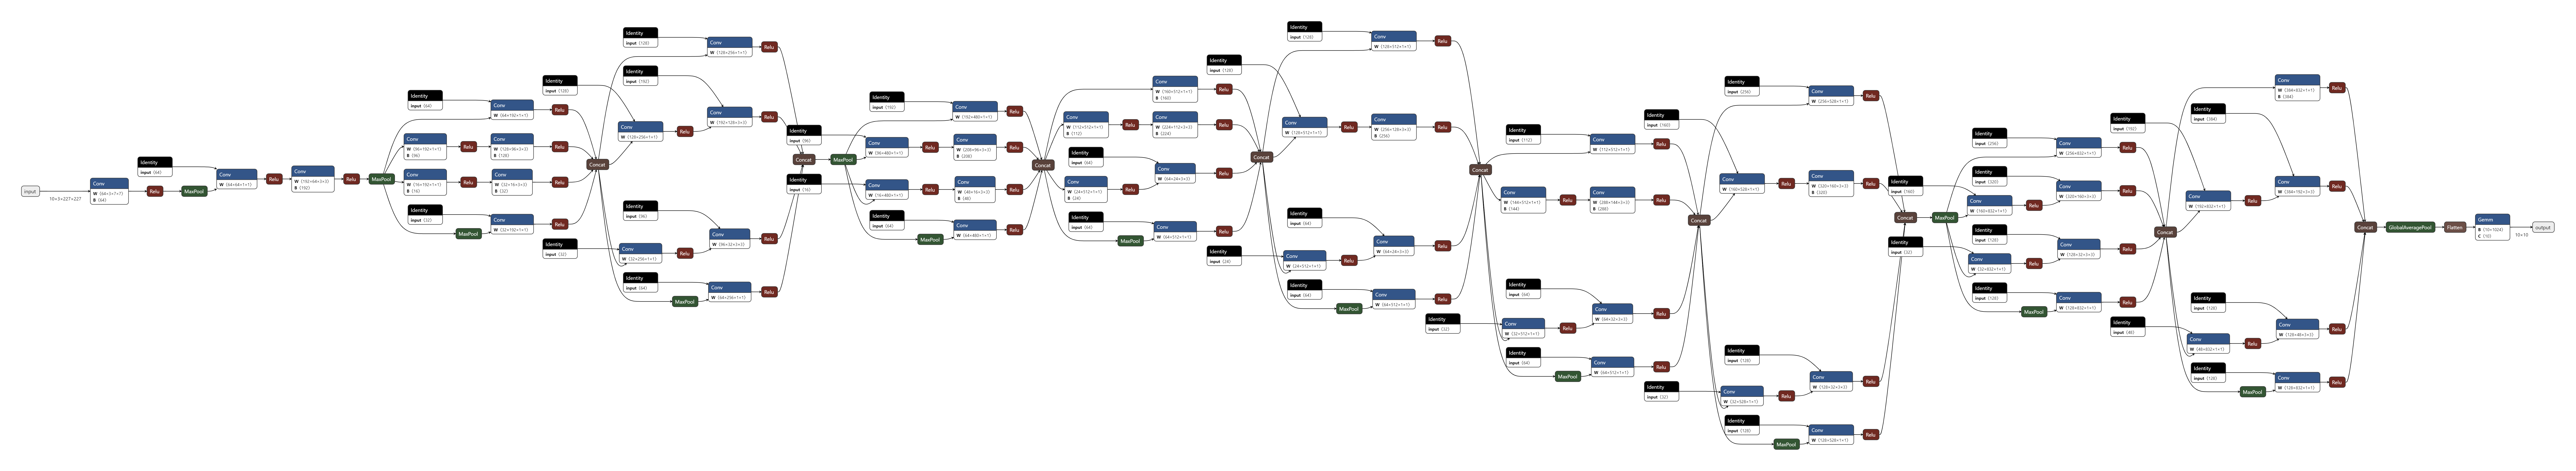

This was translated into code below:

In [ ]:
class GoogLeNet(nn.Module):
    __constants__ = ['aux_logits', 'transform_input']

    def __init__(self, num_classes=1000, aux_logits=True, transform_input=False, init_weights=None,
                 blocks=None):
        super(GoogLeNet, self).__init__()
        if blocks is None:
            blocks = [BasicConv2d, Inception, InceptionAux]
        if init_weights is None:
            init_weights = True
        assert len(blocks) == 3
        conv_block = blocks[0]
        inception_block = blocks[1]
        inception_aux_block = blocks[2]

        self.aux_logits = aux_logits
        self.transform_input = transform_input

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv2 = conv_block(64, 64, kernel_size=1)
        self.conv3 = conv_block(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = inception_aux_block(512, num_classes)
            self.aux2 = inception_aux_block(528, num_classes)
        else:
            self.aux1 = None
            self.aux2 = None

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                import scipy.stats as stats
                X = stats.truncnorm(-2, 2, scale=0.01)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _transform_input(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return x

    def _forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        aux1 = torch.jit.annotate(Optional[Tensor], None)
        if self.aux1 is not None:
            if self.training:
                aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        aux2 = torch.jit.annotate(Optional[Tensor], None)
        if self.aux2 is not None:
            if self.training:
                aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    @torch.jit.unused
    def eager_outputs(self, x, aux2, aux1):
        if self.training and self.aux_logits:
            return _GoogLeNetOutputs(x, aux2, aux1)
        else:
            return x

    def forward(self, x):
        x = self._forward(x)
        return x

class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj,
                 conv_block=None):
        super(Inception, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1),
            conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            conv_block(ch5x5red, ch5x5, kernel_size=3, padding=1)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1)
        )

    def _forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes, conv_block=None):
        super(InceptionAux, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.adaptive_avg_pool2d(x, (4, 4))
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.7, training=self.training)
        x = self.fc2(x)
        return x

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

A summary of GoogLeNet is shown below:

In [ ]:
num_classes = 10

model = GoogLeNet(num_classes).to(device)
summary(model,(3,227,227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
       BasicConv2d-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
       BasicConv2d-7           [-1, 64, 57, 57]               0
            Conv2d-8          [-1, 192, 57, 57]         110,592
       BatchNorm2d-9          [-1, 192, 57, 57]             384
      BasicConv2d-10          [-1, 192, 57, 57]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

GoogLeNet was found to be a very complicated as seen from the diagram. Therefore, we decided to try AlexNet which was simpler.

**AlexNet**


AlexNet is a CNN designed by Alex Krizhevsky which won the ImageNet Large-Scale Visual Recognition Challenge 2012 (ILSVRC12) with a top 5 error rate of 15.3% compared to a top 26.2% error rate. The architecture consists of 8 layers: 5 convolutional layers and 3 fully connected layers, with some additional features that are used as a new approach to convolutional neural networks at that time. The most prominent one was using ReLU nonlinearity. AlexNet uses Rectified Linear Units (ReLU) instead of the tanh function which was standard at the time. The power of ReLU is in training. CNN with ReLU achieved a 25% error on the CIFAR-10 dataset 6 times faster than CNN with tanh.


However, AlexNet has 60 million parameters, which is a big problem in terms of overfitting. This is solved with Dropout. This method consists of turning off neurons with a predetermined probability, which means that each iteration uses a different pattern of model parameters, allowing each neuron to have a more stable function that can be used with any other random neuron. The layers of AlexNet are shown diagrammatically below:


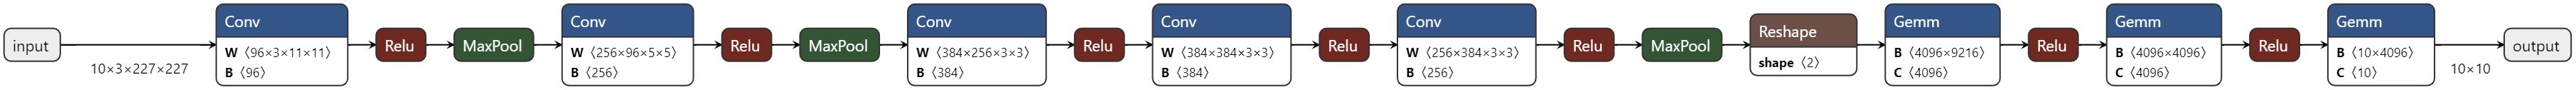

This was translated into a code implementation shown below:

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

A summary of AlexNet is also shown below:

In [ ]:
num_classes = 10

model = AlexNet(num_classes).to(device)
summary(model,(3,227,227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
       BatchNorm2d-2           [-1, 96, 55, 55]             192
              ReLU-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
       BatchNorm2d-6          [-1, 256, 27, 27]             512
              ReLU-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
      BatchNorm2d-10          [-1, 384, 13, 13]             768
             ReLU-11          [-1, 384, 13, 13]               0
           Conv2d-12          [-1, 384, 13, 13]       1,327,488
      BatchNorm2d-13          [-1, 384, 13, 13]             768
             ReLU-14          [-1, 384,

Different experiments were then conducted on the AlexNet model, tuning the Learning Rate, the Number of Epochs, the Batch Size, the Optimiser and Loss Function in order to obtain the best possible combination of hyperparameters.
Data Augmentation was also introduced to allow for different scenarios to be learned by the model. PyTorch has simplified this process by the AutoAugment function.

**Custom Network**

We still thought that the AlexNet module took too long to train due to it having almost 60 million parameters, and therefore came up with an even simpler model. Our model had 4 layers, which was half that of AlexNet. This is shown diagrammatically below:

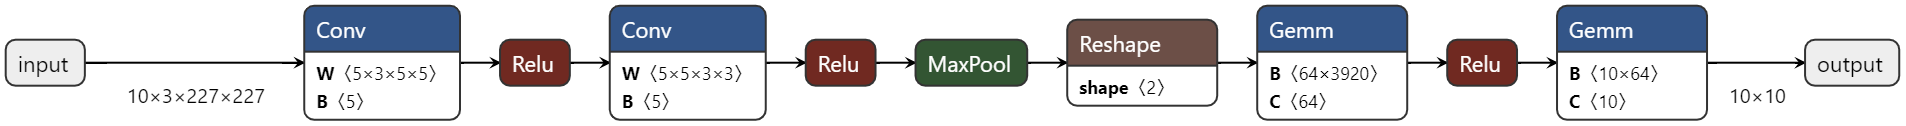

This was implemented in the code below:

In [ ]:
class Network(nn.Module):
    def __init__(self, num_classes=10):
        super(Network, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=4, padding=1),
            nn.BatchNorm2d(5),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(5),
            nn.ReLU(),
            nn.MaxPool2d(3,2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(3920, 64),
            nn.ReLU())
        self.fc1= nn.Sequential(
            nn.Linear(64, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        return out

A summary of this Network is shown below:

In [ ]:
num_classes = 10
model = Network(num_classes).to(device)
summary(model,(3,227,227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 57, 57]             380
       BatchNorm2d-2            [-1, 5, 57, 57]              10
              ReLU-3            [-1, 5, 57, 57]               0
            Conv2d-4            [-1, 5, 57, 57]             230
       BatchNorm2d-5            [-1, 5, 57, 57]              10
              ReLU-6            [-1, 5, 57, 57]               0
         MaxPool2d-7            [-1, 5, 28, 28]               0
           Dropout-8                 [-1, 3920]               0
            Linear-9                   [-1, 64]         250,944
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 252,224
Trainable params: 252,224
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.59
Forward/

Thus, by having a model with only 250,000 parameters compared to AlexNet's 60 million, we hoped that this model could be trained faster while still maintaining its accuracy.

# Results
**Results are clearly shown, discussed, evaluated using appropriate metrics. Good use of graphs or other visualizations, where possible. Comparison with previous methods/SoTA, where appropriate.**

Based on the observation of aforementioned models, firstly it could be seen that the GoogLeNet achieved a very highly accurate result, which is 99.8% accuracy. However, due to the number of layers and complexity of the network, it took about 1 hour to train 20 epochs. Thus, another method was sought after. Next, it was found that AlexNet could achieve the same level of accuracy with a less complicated network. Running AlexNet to train 20 epochs required 30 mins with a 99.5% accuracy. Hence, AlexNet was chosen as the better model for this hand gesture recognition assignment.

## Hyperparameter Tuning

Our group then decided to perform hyperparameter tuning on AlexNet in order to determine the best learning rate, number of epochs, batch size, optimiser and loss function to use. We modified each hyperparameter to see how any of the parameters affected the accuracy and run time. As reference, the following parameters were set as the initial conditions:

| Learning Rate | Epochs | Batch Size | Optimiser |   Loss Function  |
|:-------------:|:------:|:----------:|:---------:|:----------------:|
|      0.01     |   20   |     64     |    SGD    | CrossEntropyLoss |

With these base parameters, ran each each of the following experiments twice and took and average for the results.



**Learning Rate**

First, the learning rate was increased to check how it affects the accuracy and run time. The results of this can seen in the table below.

| Learning Rate | Epochs | Batch Size | Optimiser |   Loss Function  | Accuracy | Time Taken to Train |
|:-------------:|:------:|:----------:|:---------:|:----------------:|----------|---------------------|
|      0.01     |   20   |     64     |    SGD    | CrossEntropyLoss |   99.91%  |  26 mins 57 seconds |
|      0.05     |   20   |     64     |    SGD    | CrossEntropyLoss |   99.82%  |  29 mins 5 seconds  |
|      0.1      |   20   |     64     |    SGD    | CrossEntropyLoss |    86.78%   | 30  mins 28 seconds |


It could be observed that the run time went up considerably long from 27 mins to 30 mins. The accuracy also suffered, going from 99.9% to 86%. Hence, the learning rate initially used is suitable for this network.



**Number of Epochs**

Secondly, we tuned the number of epochs. The result of this is shown in the table below.

| Learning Rate | Epochs | Batch Size | Optimiser |   Loss Function  | Accuracy | Time Taken to Train |
|:-------------:|:------:|:----------:|:---------:|:----------------:|----------|---------------------|
|      0.01     |    5   |     64     |    SGD    | CrossEntropyLoss |   99.83%  |   7 mins 2 seconds  |
|      0.01     |   10   |     64     |    SGD    | CrossEntropyLoss |   99.93%  |  14 mins 19 seconds |
|      0.01     |   15   |     64     |    SGD    | CrossEntropyLoss |   99.94%  |  21 mins 8 seconds  |
|      0.01     |   20   |     64     |    SGD    | CrossEntropyLoss |   99.96%  |  29 mins 11 seconds |

By increasing the number of epochs, the run time did increase, as expected as the network had a greater number of epochs to run. On the other hand, the accuracy improved too, even though only slightly. At 20 epochs, an accuracy of 99.96% is obtained. The accuracy of the initial model was already good enough at 99.83%, which causes the difference to be hardly noticeable.



**Batch Size**

Next, the batch size is tuned to observe the change in accuracy and time taken to train as well. This is shown in the table below.

| Learning Rate | Epochs | Batch Size | Optimiser | Loss Function    | Accuracy    | Time taken to train   |
|---------------|--------|------------|-----------|------------------|-------------|-----------------------|
| 0.01          | 20     | 32         | SGD       | CrossEntropyLoss | 99.82% | 28 minutes 3 seconds  |
| 0.01          | 20     | 64         | SGD       | CrossEntropyLoss | 99.95% | 28 minutes 9 seconds |
| 0.01          | 20     | 128        | SGD       | CrossEntropyLoss | 99.93% | 31 minutes 36 seconds |

The results showed that batch size of 64 got the highest accuracy out of all with the least run time too. It took 28 minutes 3 seconds for the network model to train the data, and achieved an accuracy of 99.95%. Batch size of 32 lacks slightly in accuracy, which is 0.1% lower. As for batch size of 128, the accuracy is on par, however it required 3 minutes longer compared to the other batch sizes. Hence, batch size of 64 is the optimal batch size for the network model.

**Optimisers**

As for optimisers, different optimisers were tried out, namely SGD, Adam, and ASGD. The table with the results is shown below.

| Learning Rate | Epochs | Batch Size | Optimiser | Loss Function    | Accuracy         | Time taken to train |
|---------------|--------|------------|-----------|------------------|------------------|---------------------|
| 0.01          | 20     | 64         | SGD       | CrossEntropyLoss | 99.93% | 28 min 5 seconds            |
| 0.01          | 20     | 64         | ADAM      | CrossEntropyLoss | 94.02%  | 28 min 38 seconds           |
| 0.01          | 20     | 64         | ASGD      | CrossEntropyLoss | 99.90% | 30 min 25 seconds           |

The results turned out to be that SGD having the highest level of accuracy of 99.8%, followed by ASGD with an accuracy of 99.3%, and lastly Adam with an accuracy of 94.0%. The run time does not differ a lot, which is around 28 mins for each of them. As such, it could be said that SGD serves as the best optimiser for this solution.



**Loss Functions**

Last but not least, several loss functions were tested to determine the one with best performance as well. The loss functions include Cross Entropy Loss, Multi Margin Loss, and NLL Loss. These are shown in the table below.

| Learning Rate | Epochs | Batch Size | Optimiser | Loss Function    | Accuracy   | Time taken to train   |
|---------------|--------|------------|-----------|------------------|------------|-----------------------|
| 0.01          | 20     | 64         | SGD       | CrossEntropyLoss |  99.67% | 28 minutes 24 seconds |
| 0.01          | 20     | 64         | SGD       | MultiMarginLoss  | 99.93% | 28 minutes 8 seconds  |
| 0.01          | 20     | 64         | SGD       | NLLLoss          |       99.90% | 28 minutes 50 seconds |


The results turned out to be that Multi Margin Loss having the highest level of accuracy of 99.93%, followed by NLL Loss with an accuracy of 99.90%, and lastly Cross Entropy Loss with an accuracy of 99.67%. The run time does not differ a lot, which is around 28 mins for each of them. As such, it could be said that Multi Margin Loss serves as the best loss function for this solution.


Thus, the following optimal hyperparameters were set.

In [ ]:
# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.01

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

## Training own model
With these hyperparameters, however, we felt that the improvements in time of about 2 minutes were still quite insignificant. Thus, we decided to try training our own model with these finalised hyperparameters. This was done using the code below:

In [ ]:
# Train the model
total_step = len(train_dataloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader): 

        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(total, 100 * correct / total)) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)


Epoch [1/10], Step [157/157], Loss: 0.3937
Accuracy of the network on the 4000 validation images: 94.575 %
Epoch [2/10], Step [157/157], Loss: 0.0211
Accuracy of the network on the 4000 validation images: 97.925 %
Epoch [3/10], Step [157/157], Loss: 0.3770
Accuracy of the network on the 4000 validation images: 98.6 %
Epoch [4/10], Step [157/157], Loss: 0.0200
Accuracy of the network on the 4000 validation images: 98.925 %
Epoch [5/10], Step [157/157], Loss: 0.0156
Accuracy of the network on the 4000 validation images: 98.15 %
Epoch [6/10], Step [157/157], Loss: 0.1186
Accuracy of the network on the 4000 validation images: 98.325 %
Epoch [7/10], Step [157/157], Loss: 0.0075
Accuracy of the network on the 4000 validation images: 99.475 %
Epoch [8/10], Step [157/157], Loss: 0.0252
Accuracy of the network on the 4000 validation images: 99.425 %
Epoch [9/10], Step [157/157], Loss: 0.0026
Accuracy of the network on the 4000 validation images: 99.35 %
Epoch [10/10], Step [157/157], Loss: 0.00

The results on the test set are shown below.

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))   


Accuracy of the network on the 6000 test images: 99.45 %


Since our model only had 250,000 parameters, it only took 12 minutes to train. But despite the much lower number of parameters, the model was still able to give a 99.5% accuracy. 

# Discussion
**Discuss the results and analysis, provide some insight about system performance, including strengths, weaknesses, limitations and possible future work.**


## Model Choice
AlexNet and GoogLeNet takes a fair amount of time to run, hence the team decided to create a new model to obtain a good level of accuracy while decreasing the run time. This resulted in the custom model mentioned above. The custom model was able to get an accuracy of 99.5%, while cutting down the run time by one minute.

This could be further proven when the parameters of each models were observed. Having more parameters to train would take more time to train the network model. By comparing all three models' number of parameters, it could be seen that GoogLeNet had 9,960,638 parameters, AlexNet had 58,325,066 parameters, while the team's custom network only had 252,224 parameters. This resulted in less time being taken to train the network model. In this case, it could be said that the team's custom model network would be the best network for the main task of gesture recognition.

As shown above, the custom network model based on AlexNet was accurate, while managing to have a reduced runtime compared to the other models listed earlier. The custom network was found to achieve an accuracy of 99.5%, after around 12 minutes of training.

A possible disadvantage or limitation of this model would be the effect of data that is not well-defined on the training process. For example, if the training data included images of obscured hands, or poorly-visible gestures, the network model would not be able to reach a level of accuracy as high as the two other models mentioned in methods section, due to its simplicity and having less layers in the model.

Hence, the network model could be further improved by determining the best balance between accuracy and runtime when training the network on less well-defined datasets. This is because real-life scenarios for gesture recognition are more likely to contain hand gesture images that are not as well-defined as the ones given in the Kaggle dataset. 


## Hyperparameter Tuning

**Learning Rate**

The base learning rate of 0.01 was found to be the best in finding a compromise between accuracy and training time. The accuracy was found to be the best compared to faster learning rates. At the same time, the faster learning rates suprisingly did not reduce the training times as much as we expected. 

**Number of Epochs**

As the number of epochs was increased, both the accuracy and the time taken to train increased. Even from having just 5 epochs, it can be seen that there is already a 99.83% accuracy which meant that the improvements in training are quite insignificant. In contrast the amount of time taken increased by about 7 minutes for every 5 epochs. Thus, after consideration, we decided that having 10 epochs was good enough for our applications.


**Batch Size**

When the batch size is too large, it tends to lead to poor generalization(trained too well on training data), causing inaccurate predictions. The time taken to train would be longer too as it requires longer time to converge. However, when the batch size is too small, it prevents the neural network from overfitting on the training set, and hence accuracy would suffer too. In this case, batch size of 64 is determined to be the sweet spot for this network model, having an accuracy of 99.95% and a training time of 28 minutes 9 seconds.

**Optimisers**

The SGD optimiser has few advantages over others that allowed it to achieve the highest accuracy with least time taken. It frequently updates model parameters; hence the convergence happens faster. It also requires less memory as there is no need to store values of loss functions. Hence, the SGD optimiser proves to be the most suitable optimiser to be used in this network model.

**Loss Function**

MultiMarginLoss was noted to have slightly better performance, but it was an extremely small margin of improvement around 0.3%. The trials was also done only twice so the reliability of MultiMarginLoss cannot be confirmed. Hence, the team decided to settle with CrossEntropyLoss as it was the loss function we started off with and it has been proven to work. 

## Summary
Hence, as seen from our results, the models and hyperparameter tuning parts were already quite accurate from the beginning, which meant that all experiments conducted only brought about a 0.2% increase or decrease in accuracy. This could be attributed to the dataset that we used. Since the images were already clear, grayscale, contained minimal noise and only contained one hand gesture in each image, even the simplest of CNNs could classify them within 5 epochs. For future developments, we could perhaps test our models and tunings with different kinds of images that have varied backgrounds. Furthermore, we could add object detection to the custom model that can identify the specific location of a hand gesture within an image before classifying the gesture.